<a href="https://colab.research.google.com/github/chenmargalit/CNN-Heatmap/blob/master/Cnn_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is heavily inspried by the wonderful Fastai course https://www.fast.ai/

## Visualizing a CNN
We're going to work with a dataset that consists of 37 classes (pets) to classify. The architecture will be a pre-trained resnet34 CNN model. We are going to create 2 models, one which is good (suitable lr) and one which is lousy (unsuitable lr). We will then visualize what the two models have learned and the result will hopefully provide an interesting insight at what CNN does.

### Getting the data

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
path = untar_data(URLs.PETS)/'images'

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2)

In [0]:
path.ls()[:5]

In [0]:
# Some useful transfomrations, see fastai docs for great examples

tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [0]:
bs = 256

In [0]:
# We are using resnet34, a pre trained model which is based on the imagenet dataset. Therefor we use it's (imagenet) stats for normalization
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [0]:
path.ls()[:3]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_136.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_46.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_103.jpg')]

In [0]:
# As can be seen, the class of the image is a part of its name. Specifically, its right between a "/" and an "_"
def get_data(sz, bs, padding_mode='reflefction'):
  return (src.label_from_re(r'([^/]+)_\d+.jpg$')
         .transform(tfms, size=sz, padding_mode=padding_mode)
          .databunch(bs=bs).normalize(imagenet_stats)
         )

In [0]:
# Reshape the image to be a rectangled (y by y) 224 X 224 image
data = get_data(224, bs, 'zeros')

In [0]:
# Colourful image (3 image channels) in the size we specified
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

In [0]:
# Exmaples for some of the 37 labels
data.label_list

LabelLists;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
British_Shorthair,shiba_inu,Persian,staffordshire_bull_terrier,basset_hound
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
german_shorthaired,japanese_chin,leonberger,keeshond,great_pyrenees
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

### Training the models
As mentioned, I will create 2 different models to visualize the difference

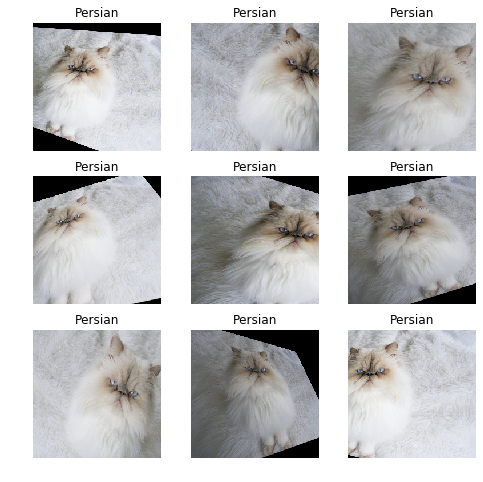

In [0]:
# Lets look at the different transformations
def plot(i, j, ax):
  x, y = data.train_ds[2]
  x.show(ax, y=y)
  
plot_multi(plot, 3, 3, figsize=(8,8))

In [0]:
# Python garbage collector, clears unused memory references
gc.collect()
# Cnn pre-trained resenet34 model with a batch norm layer.
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [0]:
# Lousy model with a bad accuracy. The only thing making it so bad is the huge lr (2.5) which makes the model miss what it needs to learn.
%time learn.fit_one_cycle(1, slice(2.5), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.522360,54.339977,0.964817,01:55


CPU times: user 17.2 s, sys: 14.2 s, total: 31.4 s
Wall time: 1min 55s


In [0]:
# Much better model, reasonable lr, trains for more time, resulting in better accuracy.
learnBetter = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)
%time learnBetter.fit_one_cycle(3, slice(1e-1), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.131034,0.513843,0.142084,01:51
1,1.293000,1.164461,0.183356,01:51
2,0.944381,0.559653,0.123816,01:51


CPU times: user 53 s, sys: 34.1 s, total: 1min 27s
Wall time: 5min 34s


Lets look at the model as its important for later. We start with a 64 filters, kernel_size=7, stride=2, padding=3 (so we dont loose information). We finish with 512 filters (inputs) and 37 outputs (number of classes). By the end of the training, the inputs are of size 7 X 7 (size gets reduced where stride > 1). In the end we get to 37 probabilities (the heighest being the one being declared as the predicted class). How does this happen ? we average pool on every 7x7 matrix, getting one number, so we end up with a vector of 512 numbers. We multiplie by a 512 x 37 matrix and we end up with what we need. This means the entire information we use for prediction lays in those 512 7x7 matrixes. Every one of these 512 filters, encapsulates a feature, maybe a tail, weight, ears size, colour etc. Each 7x7 matrix represents how activated is this feature. Does it have a tail ? what size ?. 

So to get a heatmap, we are actually going to do the same, with a minor twick. We are going to average on the 512 filters, instead of the 7x7 matrix. What we're going to get is a representation of what part of the image was the most meaningful for making the decision. This will tell us what did the network find important, while deciding on the class. We could imagine that if there's a huge grassyard and a dog on the side, the most activated place would be around the dog, as focusing on the grass will not allow us to understand wether its a beagle or a staffordshire bull terrier (whatever that is).

In [0]:
# Uncomment to see the structure of the model. As we can see here, we end with 512 filters of 7x7. Downsampling can be done both with a convolutional
# opearation (stride=2) or with a max pool. Both has pros and cons. Doing it in the convolutional operation can be more expensive, compared to maxpooling
# which learns no parameters. On the other hand, as it operates with other things (the rest of the convolutional process) it can be beneficial as well.
# Resnet for example uses stride for downsmapling in the first layer which reduced the computational cost.
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

### Filter creation
How does a convolutional operation work? a filter is a matrix, lets say 3x3 that goes over the entire image 3x3 pixels at a time (assuming stride=1), does an element-wise multiplication (every number in the matrix gets multiplied by one number in the image) and sums the calculation to one number. Basically what we get is how activated is this 3x3 area in the image. As you probably imagine, the filter itself has a huge influence. True. This is why we use different filters for different stages, in large, the first filters are more simple, they try to detect very obvious large patterns, maybe the edges of the image. The next filters will rely on the previous's work and will try to detect mroe complicated patterns. There are some optimization steps and a few other details but thats the big picture


So I will create my own filter which as we can see, is supposed to detect edges (the one's)

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [0]:
# First image of validation, could be any image.
x,y = data.valid_ds[0]

In [0]:
# Size as expected
x.shape

torch.Size([3, 224, 224])

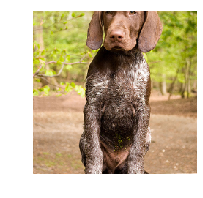

In [0]:
x.show()

In [0]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 224, 224])

In [0]:
# Kernal axis is a 3 rank tensor, built out of number of filters, height, width. In pytorch specifically everything is expected to be a batch
# so we need to add another unit axis. 
edge = F.conv2d(t[None], k)
# 4 rank tensor as expected by Pytorch
edge.shape

torch.Size([1, 1, 222, 222])

And here it is, the filter actually enabled us to create the shape of the animal. That could maybe even be enough if we would want easily classified pets like a dog vs a bird. If however the differences would be more subtle (size of the ear, color etc, we would need more accuracy)

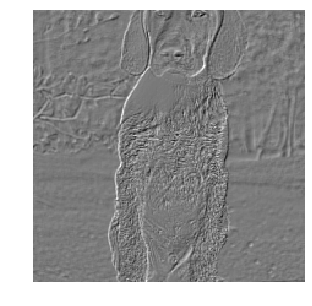

In [0]:
show_image(edge[0], figsize=(5,5));

### Hooks

Hooks are a pytorch feature that lets us do something (function) in some part of the model. What we want to do is make the model save what is calculated, although its not built in. The part we need is the activations being calculated while training, so we can visualize it.

In [0]:
# No training needed here. Model is in inference mode
m = learn.model.eval(); 

In [0]:
# As pytorch expects a minibatch, fastai's one_item method will do it for us (as well as normalizing)
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
# Put on the gpu for additional speed. * if you are not using a GPU this line will not run
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
  # We are using the context manager here as the next hook we'll calculate will be accumulated to this one, Pytorch doesnt automatically deletes it.
  # The with keyword (context manager) will take care of this.
  # m[0] is the first part of the model, the convolutional part. This is the part we need
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
          # Pytorch is built using the __call__ method so we can just call it as a function. We actually don't care about the prediction
          # but we need this part to get the activations which will be stored in hook_a
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

In [0]:
# In fastai, the activations will be in the .stored part of the hook. We can see its a 512 by 7x7 tensor
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 7, 7])

In [0]:
# Lets average this on the filters (e.g in our context - activations)
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [0]:
# Lets plot what we just calculated, extending it to 352x352 as 7x7 won't be very clear
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

And we've got it. This is a heatmap showing the activations used to decide on the class of this dog. As we can maybe suspect, this isn't exactly catching all the most important features. This is as mentioned, the bad model

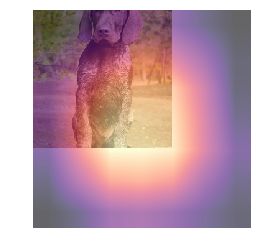

In [0]:
show_heatmap(avg_acts)

### Good model
Exactly the same, with the better model

In [0]:
mBetter = learnBetter.model.eval();

In [0]:
x,y = data.valid_ds[0]

In [0]:
xbBetter,_ = data.one_item(x)
xb_imBetter = Image(data.denorm(xbBetter)[0])
xbBetter = xbBetter.cuda()

In [0]:
from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
    with hook_output(mBetter[0]) as hook_aBetter: 
        with hook_output(mBetter[0], grad=True) as hook_gBetter:
            preds = mBetter(xbBetter)
            preds[0,int(cat)].backward()
    return hook_aBetter,hook_gBetter

In [0]:
hook_aBetter,hook_gBetter = hooked_backward()

In [0]:
actsBetter  = hook_aBetter.stored[0].cpu()
actsBetter.shape

torch.Size([512, 7, 7])

In [0]:
avg_actsBetter = actsBetter.mean(0)
avg_actsBetter.shape

torch.Size([7, 7])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

### Final comparison

As we can very easily see. The main focus of the models is different. 
* The model splits the data randomly, I kept it like this so you can run this algorithm multiplie times and get the same kind of results with different examples. The downside is that I can't exactly describe the differences in heatmaps as you will see different examples, but I'm sure you can easily notice.


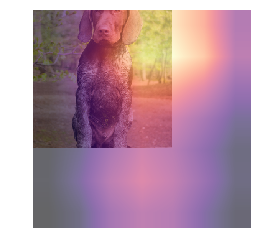

In [0]:
# Good model
show_heatmap(avg_actsBetter)

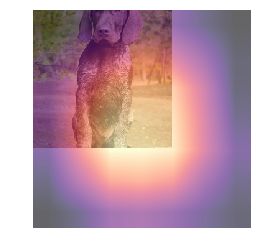

In [0]:
show_heatmap(avg_acts)